In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [169]:
# 读取数据
df = pd.read_excel("股票数据.xlsx")

In [170]:
df.head()

,ts_code,trade_date,open,high,low,close,vol,name
0,600519.SH,20231030,1669.00,1688.88,1669.00,1681.00,24086.42,贵州茅台
1,600519.SH,20231027,1664.00,1691.88,1660.60,1676.71,34262.39,贵州茅台
2,600519.SH,20231026,1667.00,1688.00,1662.01,1672.23,22386.35,贵州茅台
3,600519.SH,20231025,1670.11,1698.00,1667.02,1677.50,36178.98,贵州茅台
4,600519.SH,20231024,1648.00,1653.36,1621.21,1642.95,29861.46,贵州茅台


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ts_code     139 non-null    object 
 1   trade_date  139 non-null    int64  
 2   open        139 non-null    float64
 3   high        139 non-null    float64
 4   low         139 non-null    float64
 5   close       139 non-null    float64
 6   vol         139 non-null    float64
 7   name        139 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 8.8+ KB


### 构造和删除列

In [172]:
# 删除 ts_code name 列
df.drop(columns=["ts_code","name"], axis=1, inplace=True)

In [173]:
# 对 trade_date 进行升序排序
df.sort_values(by="trade_date", inplace=True)
df.reset_index(drop=True, inplace=True)

In [174]:
df

,trade_date,open,high,low,close,vol
0,20230403,1825.00,1827.77,1800.08,1802.07,21417.43
1,20230404,1812.00,1815.17,1787.00,1814.59,20066.26
2,20230406,1805.00,1815.90,1788.22,1796.96,14874.22
3,20230407,1795.00,1806.01,1788.34,1790.99,13524.68
4,20230410,1790.88,1790.88,1744.00,1771.70,29418.22
...,...,...,...,...,...,...
134,20231024,1648.00,1653.36,1621.21,1642.95,29861.46
135,20231025,1670.11,1698.00,1667.02,1677.50,36178.98
136,20231026,1667.00,1688.00,1662.01,1672.23,22386.35
137,20231027,1664.00,1691.88,1660.60,1676.71,34262.39


In [175]:
# 将 trade_date 转成时间格式
df["trade_date"] = pd.to_datetime(df["trade_date"], format="%Y%m%d")
df

,trade_date,open,high,low,close,vol
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22
...,...,...,...,...,...,...
134,2023-10-24,1648.00,1653.36,1621.21,1642.95,29861.46
135,2023-10-25,1670.11,1698.00,1667.02,1677.50,36178.98
136,2023-10-26,1667.00,1688.00,1662.01,1672.23,22386.35
137,2023-10-27,1664.00,1691.88,1660.60,1676.71,34262.39


In [176]:
# 构建 10月31日 到 11月3日 的时间序列
dates = pd.bdate_range('20231031', periods=5)
print(dates)

DatetimeIndex(['2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03',
               '2023-11-06'],
              dtype='datetime64[ns]', freq='B')


In [177]:
l = df.shape[0]
# 将其添加到 df 中
for i in range(len(dates)):
    df.loc[l+i, "trade_date"] = dates[i]
df   

,trade_date,open,high,low,close,vol
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22
...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN
140,2023-11-01,NaN,NaN,NaN,NaN,NaN
141,2023-11-02,NaN,NaN,NaN,NaN,NaN
142,2023-11-03,NaN,NaN,NaN,NaN,NaN


In [178]:
# 构造D列
D = df["trade_date"].unique()
D_dict = {}
i = 1
for each_D in D:
    D_dict[each_D] = i
    i += 1

df['D'] = df['trade_date'].map(D_dict)

df

,trade_date,open,high,low,close,vol,D
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5
...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143


In [179]:
# 判断每个日期属于星期几,其中 Monday 为 0，Tuesday 为 1，以此类推
df['week_day'] = df['trade_date'].dt.dayofweek
df

,trade_date,open,high,low,close,vol,D,week_day
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0
...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4


In [180]:
# 判断月初 月中 月末
yczm = []
mr = []
for i in df.index:
    items = int(str(df.loc[i,'trade_date']).split(' ')[0].split("-")[-1])
    mr.append(items)
    if items < 10:
        yczm.append('月初')
    elif items < 20:
        yczm.append('月中')
    else:
        yczm.append('月末')
df['日'] = mr
df['时间段'] = yczm
df

,trade_date,open,high,low,close,vol,D,week_day,日,时间段
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0,3,月初
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1,4,月初
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3,6,月初
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4,7,月初
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0,10,月中
...,...,...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1,31,月末
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2,1,月初
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3,2,月初
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4,3,月初


### 特征工程

##### 滞后工程

In [181]:
# 单位是天
lags = [1,2,3,5,7,10,14]
for lag in lags:
    df['open_lag_'+str(lag)] = df['open'].shift(lag).astype(np.float64)
    df['close_lag_'+str(lag)] = df['close'].shift(lag).astype(np.float64)
df

,trade_date,open,high,low,close,vol,D,week_day,日,时间段,...,open_lag_3,close_lag_3,open_lag_5,close_lag_5,open_lag_7,close_lag_7,open_lag_10,close_lag_10,open_lag_14,close_lag_14
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0,3,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1,4,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3,6,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4,7,月初,...,1825.0,1802.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0,10,月中,...,1812.0,1814.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1,31,月末,...,1667.0,1672.23,1648.00,1642.95,1630.00,1645.00,1739.00,1726.00,1784.65,1778.5
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2,1,月初,...,1664.0,1676.71,1670.11,1677.50,1629.97,1643.98,1718.80,1728.00,1797.90,1786.0
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3,2,月初,...,1669.0,1681.00,1667.00,1672.23,1648.00,1642.95,1700.00,1630.00,1770.88,1751.0
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4,3,月初,...,NaN,NaN,1664.00,1676.71,1670.11,1677.50,1630.00,1645.00,1750.98,1729.9


##### 均值编码

In [182]:
df['时间段_open_region_code_ord_qty_avg'] = df.groupby(['时间段'])['open'].transform('mean').astype(np.float64)
df['week_day_open_avg'] = df.groupby(['week_day'])['open'].transform('mean').astype(np.float64)

df['时间段_close_region_code_ord_qty_avg'] = df.groupby(['时间段'])['close'].transform('mean').astype(np.float64)
df['week_day_close_avg'] = df.groupby(['week_day'])['close'].transform('mean').astype(np.float64)

df

,trade_date,open,high,low,close,vol,D,week_day,日,时间段,...,open_lag_7,close_lag_7,open_lag_10,close_lag_10,open_lag_14,close_lag_14,时间段_open_region_code_ord_qty_avg,week_day_open_avg,时间段_close_region_code_ord_qty_avg,week_day_close_avg
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0,3,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,1779.846176,1762.546552,1776.850882,1759.407586
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1,4,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,1779.846176,1765.298214,1776.850882,1763.246786
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3,6,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,1779.846176,1761.611429,1776.850882,1758.623214
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4,7,月初,...,NaN,NaN,NaN,NaN,NaN,NaN,1779.846176,1758.139259,1776.850882,1759.324815
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0,10,月中,...,NaN,NaN,NaN,NaN,NaN,NaN,1757.816923,1762.546552,1753.492308,1759.407586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1,31,月末,...,1630.00,1645.00,1739.00,1726.00,1784.65,1778.5,1755.882075,1765.298214,1755.681887,1763.246786
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2,1,月初,...,1629.97,1643.98,1718.80,1728.00,1797.90,1786.0,1779.846176,1764.663704,1776.850882,1759.582222
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3,2,月初,...,1648.00,1642.95,1700.00,1630.00,1770.88,1751.0,1779.846176,1761.611429,1776.850882,1758.623214
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4,3,月初,...,1670.11,1677.50,1630.00,1645.00,1750.98,1729.9,1779.846176,1758.139259,1776.850882,1759.324815


##### 滑动窗口统计

In [183]:
# 以5天作为窗口移动大小
df['rolling_open_mean'] = df['open'].transform(lambda x: x.rolling(window=5).mean()).astype(np.float64)
df['rolling_close_mean'] = df['close'].transform(lambda x: x.rolling(window=5).mean()).astype(np.float64)

df

,trade_date,open,high,low,close,vol,D,week_day,日,时间段,...,open_lag_10,close_lag_10,open_lag_14,close_lag_14,时间段_open_region_code_ord_qty_avg,week_day_open_avg,时间段_close_region_code_ord_qty_avg,week_day_close_avg,rolling_open_mean,rolling_close_mean
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0,3,月初,...,NaN,NaN,NaN,NaN,1779.846176,1762.546552,1776.850882,1759.407586,NaN,NaN
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1,4,月初,...,NaN,NaN,NaN,NaN,1779.846176,1765.298214,1776.850882,1763.246786,NaN,NaN
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3,6,月初,...,NaN,NaN,NaN,NaN,1779.846176,1761.611429,1776.850882,1758.623214,NaN,NaN
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4,7,月初,...,NaN,NaN,NaN,NaN,1779.846176,1758.139259,1776.850882,1759.324815,NaN,NaN
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0,10,月中,...,NaN,NaN,NaN,NaN,1757.816923,1762.546552,1753.492308,1759.407586,1805.576,1795.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1,31,月末,...,1739.00,1726.00,1784.65,1778.5,1755.882075,1765.298214,1755.681887,1763.246786,NaN,NaN
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2,1,月初,...,1718.80,1728.00,1797.90,1786.0,1779.846176,1764.663704,1776.850882,1759.582222,NaN,NaN
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3,2,月初,...,1700.00,1630.00,1770.88,1751.0,1779.846176,1761.611429,1776.850882,1758.623214,NaN,NaN
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4,3,月初,...,1630.00,1645.00,1750.98,1729.9,1779.846176,1758.139259,1776.850882,1759.324815,NaN,NaN


##### 开窗

In [184]:
df['expanding_open_mean'] = df['open'].transform(lambda x: x.expanding(3).mean()).astype(np.float16)
df['expanding_close_mean'] = df['close'].transform(lambda x: x.expanding(3).mean()).astype(np.float16)
df

,trade_date,open,high,low,close,vol,D,week_day,日,时间段,...,open_lag_14,close_lag_14,时间段_open_region_code_ord_qty_avg,week_day_open_avg,时间段_close_region_code_ord_qty_avg,week_day_close_avg,rolling_open_mean,rolling_close_mean,expanding_open_mean,expanding_close_mean
0,2023-04-03,1825.00,1827.77,1800.08,1802.07,21417.43,1,0,3,月初,...,NaN,NaN,1779.846176,1762.546552,1776.850882,1759.407586,NaN,NaN,NaN,NaN
1,2023-04-04,1812.00,1815.17,1787.00,1814.59,20066.26,2,1,4,月初,...,NaN,NaN,1779.846176,1765.298214,1776.850882,1763.246786,NaN,NaN,NaN,NaN
2,2023-04-06,1805.00,1815.90,1788.22,1796.96,14874.22,3,3,6,月初,...,NaN,NaN,1779.846176,1761.611429,1776.850882,1758.623214,NaN,NaN,1814.0,1805.0
3,2023-04-07,1795.00,1806.01,1788.34,1790.99,13524.68,4,4,7,月初,...,NaN,NaN,1779.846176,1758.139259,1776.850882,1759.324815,NaN,NaN,1809.0,1801.0
4,2023-04-10,1790.88,1790.88,1744.00,1771.70,29418.22,5,0,10,月中,...,NaN,NaN,1757.816923,1762.546552,1753.492308,1759.407586,1805.576,1795.262,1806.0,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2023-10-31,NaN,NaN,NaN,NaN,NaN,140,1,31,月末,...,1784.65,1778.5,1755.882075,1765.298214,1755.681887,1763.246786,NaN,NaN,1762.0,1760.0
140,2023-11-01,NaN,NaN,NaN,NaN,NaN,141,2,1,月初,...,1797.90,1786.0,1779.846176,1764.663704,1776.850882,1759.582222,NaN,NaN,1762.0,1760.0
141,2023-11-02,NaN,NaN,NaN,NaN,NaN,142,3,2,月初,...,1770.88,1751.0,1779.846176,1761.611429,1776.850882,1758.623214,NaN,NaN,1762.0,1760.0
142,2023-11-03,NaN,NaN,NaN,NaN,NaN,143,4,3,月初,...,1750.98,1729.9,1779.846176,1758.139259,1776.850882,1759.324815,NaN,NaN,1762.0,1760.0


In [185]:
# 对 时间段 列进行编码
dct = {"月初":1, "月中":2, "月末":3}
df["时间段"] = df["时间段"].apply(lambda x:dct[x])

___

### XGBoost模型

In [186]:
data = df.drop(columns=["trade_date", "high", "low", "vol"], axis=1)
data.head()

,open,close,D,week_day,日,时间段,open_lag_1,close_lag_1,open_lag_2,close_lag_2,...,open_lag_14,close_lag_14,时间段_open_region_code_ord_qty_avg,week_day_open_avg,时间段_close_region_code_ord_qty_avg,week_day_close_avg,rolling_open_mean,rolling_close_mean,expanding_open_mean,expanding_close_mean
0,1825.00,1802.07,1,0,3,1,NaN,NaN,NaN,NaN,...,NaN,NaN,1779.846176,1762.546552,1776.850882,1759.407586,NaN,NaN,NaN,NaN
1,1812.00,1814.59,2,1,4,1,1825.0,1802.07,NaN,NaN,...,NaN,NaN,1779.846176,1765.298214,1776.850882,1763.246786,NaN,NaN,NaN,NaN
2,1805.00,1796.96,3,3,6,1,1812.0,1814.59,1825.0,1802.07,...,NaN,NaN,1779.846176,1761.611429,1776.850882,1758.623214,NaN,NaN,1814.0,1805.0
3,1795.00,1790.99,4,4,7,1,1805.0,1796.96,1812.0,1814.59,...,NaN,NaN,1779.846176,1758.139259,1776.850882,1759.324815,NaN,NaN,1809.0,1801.0
4,1790.88,1771.70,5,0,10,2,1795.0,1790.99,1805.0,1796.96,...,NaN,NaN,1757.816923,1762.546552,1753.492308,1759.407586,1805.576,1795.262,1806.0,1795.0


In [187]:
# 数据集划分
valid = data[(data['D']>=125) & (data['D']<=139)][['D','open','close']]
test = data[data['D']>139][['D','open','close']]
XGB_eval_preds = test[['open','close']]    # 待预测 目前全为0
valid_preds = valid[['D','open','close']] 

[0]	validation_0-rmse:65.70263	validation_1-rmse:82.90430
[10]	validation_0-rmse:60.19120	validation_1-rmse:77.34032
[20]	validation_0-rmse:55.14305	validation_1-rmse:72.74647
[30]	validation_0-rmse:50.56988	validation_1-rmse:69.18497
[40]	validation_0-rmse:46.34530	validation_1-rmse:64.87175
[50]	validation_0-rmse:42.53306	validation_1-rmse:61.40971
[60]	validation_0-rmse:39.06950	validation_1-rmse:58.42363
[70]	validation_0-rmse:35.88738	validation_1-rmse:55.39034
[80]	validation_0-rmse:33.00492	validation_1-rmse:53.49646
[90]	validation_0-rmse:30.37019	validation_1-rmse:51.83327
[100]	validation_0-rmse:27.95406	validation_1-rmse:50.23571
[110]	validation_0-rmse:25.74493	validation_1-rmse:48.40273
[120]	validation_0-rmse:23.76186	validation_1-rmse:46.80814
[130]	validation_0-rmse:21.91976	validation_1-rmse:45.55728
[140]	validation_0-rmse:20.25390	validation_1-rmse:44.49934
[150]	validation_0-rmse:18.71675	validation_1-rmse:43.41676
[160]	validation_0-rmse:17.32311	validation_1-rmse:

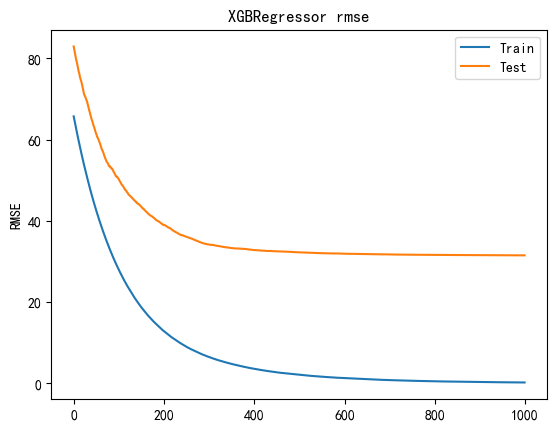

In [188]:
# Split the data
X_train, y_train = data[data['D'] < 125].drop(columns=["open","close"], axis=1), data[data['D'] < 125][["open","close"]]
X_valid, y_valid = data[(data['D'] >= 125) & (data['D'] <= 139)].drop(columns=["open","close"], axis=1), \
data[(data['D'] >= 125) & (data['D'] <= 139)][["open","close"]]
X_test = data[data['D'] > 139].drop(columns=["open","close"], axis=1)

# Train and validate
model = XGBRegressor(
    n_estimators=1000,     # 要构建树的数量
    learning_rate=0.01,     # 学习率
    subsample=0.9,         # 训练集的子样本数
    colsample_bytree=0.5,  # 每次迭代中随机选择特征的比例
    # max_depth=20,           # 树的最大深度
    # num_leaves=64,         # 每颗树上叶节点的数量
    # min_child_weight=10   # 叶节点最少需要的样本数量
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric='rmse',verbose=10, early_stopping_rounds=15)


valid_preds[['open', 'close']] = pd.DataFrame(model.predict(X_valid), index=X_valid.index)
eval_preds = X_test[["D"]]
eval_preds[['open', 'close']] = pd.DataFrame(model.predict(X_test), index=X_test.index)



# 画图
# 获取训练集和验证集上的损失函数值
train_results = model.evals_result()['validation_0']['rmse']
val_results = model.evals_result()['validation_1']['rmse']

epochs = len(train_results)
x_axis = range(0, epochs)

# 均方根误差
fig, ax = plt.subplots()
ax.plot(x_axis, train_results, label='Train')
ax.plot(x_axis, val_results, label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBRegressor rmse')
plt.show()

In [192]:
# 预测结果
pd.merge(eval_preds,df[["trade_date","D"]],on="D")

,D,open,close,trade_date
0,140,1753.537720,1762.298584,2023-10-31
1,141,1819.531738,1795.408081,2023-11-01
2,142,1828.862061,1806.587769,2023-11-02
3,143,1828.733643,1813.635498,2023-11-03
4,144,1831.855225,1812.320679,2023-11-06


In [190]:
# 测试集真实值
y_valid

,open,close
124,1782.89,1770.00
125,1784.65,1778.50
126,1797.90,1786.00
127,1770.88,1751.00
128,1750.98,1729.90
129,1739.00,1726.00
130,1718.80,1728.00
131,1700.00,1630.00
132,1630.00,1645.00
133,1629.97,1643.98


In [191]:
# 测试集预测值
valid_preds

,D,open,close
124,125,1798.670776,1788.253418
125,126,1789.813477,1776.399048
126,127,1794.923096,1784.252563
127,128,1795.556885,1788.481201
128,129,1770.539917,1751.570190
129,130,1747.575195,1742.415771
130,131,1730.667847,1741.257690
131,132,1730.345337,1738.862305
132,133,1670.998779,1701.861816
133,134,1669.630127,1685.960449
